## Kalashnik et Kalashnik 2011 - Tests

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [132]:
def vm(t, lbda=1.5):
    num = np.exp(-t) - np.exp((1 - lbda) * t)
    den = lbda - 2
    return num /den

def rm(t):
    return np.exp(-t)

In [3]:
# lbda = 1.5 # lambda parameter
# ts   = np.linspace(0, 10, 1000)

# for lbda in [0.9, 1.1, 1.5, 1.9, 2.1]:
#     plt.title('Lambda = {}'.format(lbda), weight='bold')
#     plt.plot(vm(ts, lbda), c='tab:red', label='Vmax')
#     plt.plot(rm(ts),       c='k',       label='Rmax')
#     plt.legend()
#     plt.grid()
#     plt.xlabel('time unit');plt.ylabel('Vm and Rm units of initial values')
#     plt.show()

/tmp/ipykernel_18121/3041417967.py:4: RuntimeWarning: invalid value encountered in true_divide
  return num /den


Text(0, 0.5, 'Vm and Rm units of initial values')

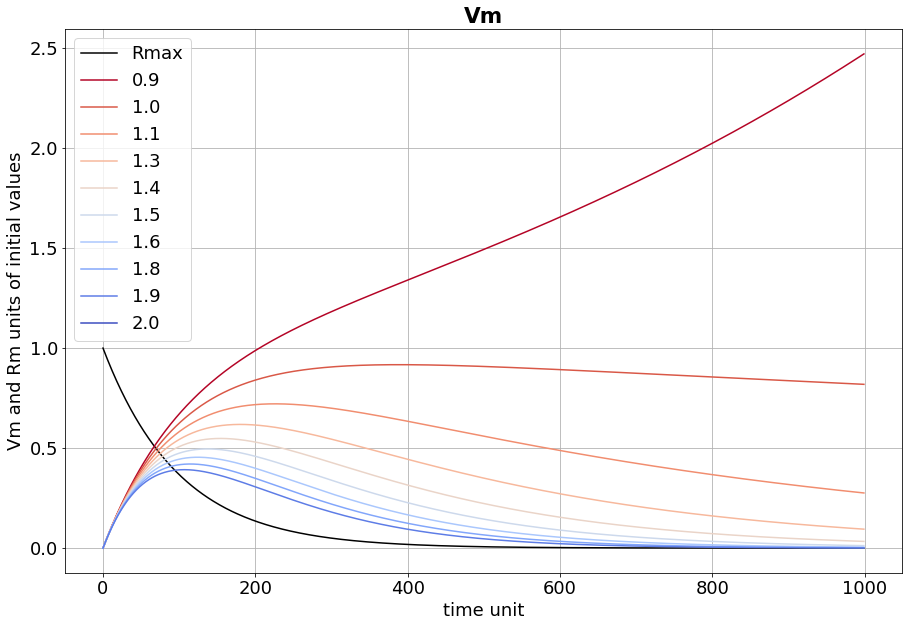

In [4]:
ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(0.9, 2, 10)
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.title('Vm', weight='bold')
plt.plot(rm(ts),       c='k',       label='Rmax')

for i, lbda in enumerate(lbdas):
    plt.plot(vm(ts, lbda), label='{:.1f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Vm and Rm units of initial values')

/tmp/ipykernel_18121/3041417967.py:4: RuntimeWarning: invalid value encountered in true_divide
  return num /den


Text(0, 0.5, 'Mm and Rm units of initial values')

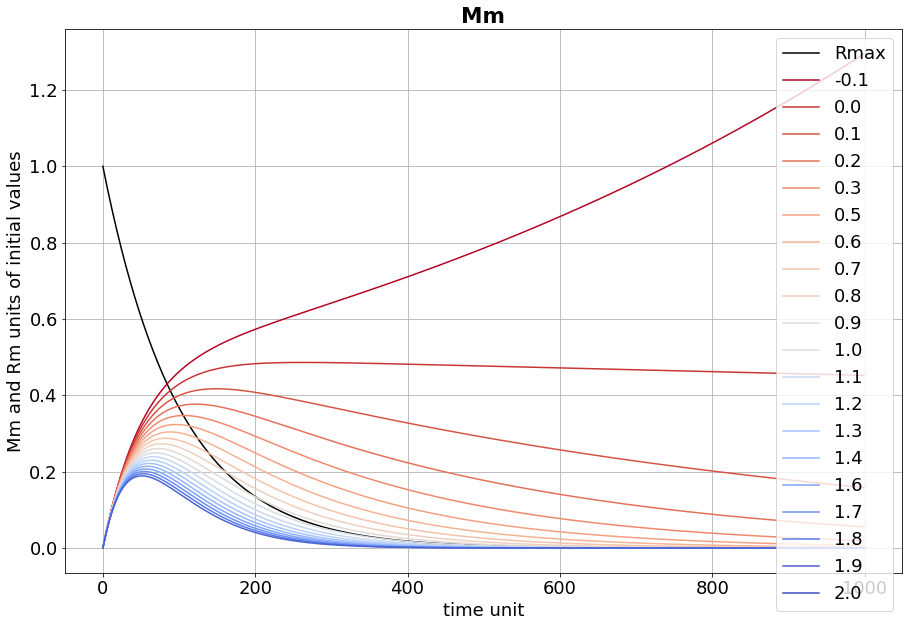

In [5]:
ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(-0.1, 2, 20)
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.title('Mm', weight='bold')
plt.plot(rm(ts),       c='k',       label='Rmax')

for i, lbda in enumerate(lbdas):
    plt.plot(rm(ts) * vm(ts, lbda), label='{:.1f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Mm and Rm units of initial values')

In [6]:
def vm2(t, lbda=1.5, tau=1.):
    num = np.exp(-t / tau) - np.exp((1 / tau - lbda) * t)
    den = lbda - (2 / tau)
    return num / den

def rm2(t, tau=1.):
    return np.exp(-t / tau)

/tmp/ipykernel_18121/1653025495.py:4: RuntimeWarning: invalid value encountered in true_divide
  return num / den


Text(0, 0.5, 'Vm and Rm units of initial values')

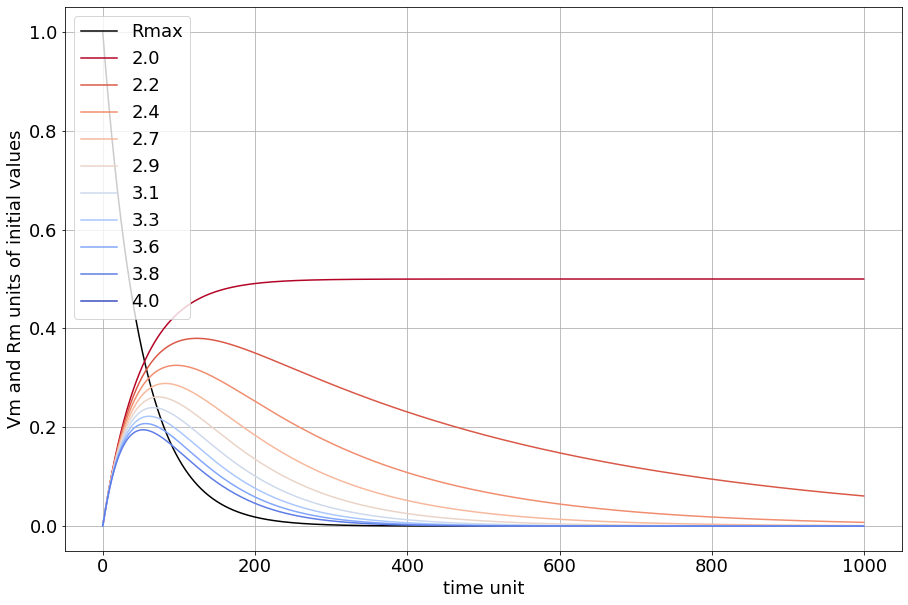

In [7]:
tau    = 0.5
ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(1, 2, 10) * (1 / tau)
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.plot(rm2(ts, tau=tau),       c='k',       label='Rmax')
for i, lbda in enumerate(lbdas):
    plt.plot(vm2(ts, lbda, tau=tau), label='{:.1f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Vm and Rm units of initial values')

In [8]:
def vm3(t, lbda=1.5, tau=1.):
    num = np.exp(tau - t) - np.exp((1 / lbda) * (t - tau))
    den = lbda - 2
    return num / den

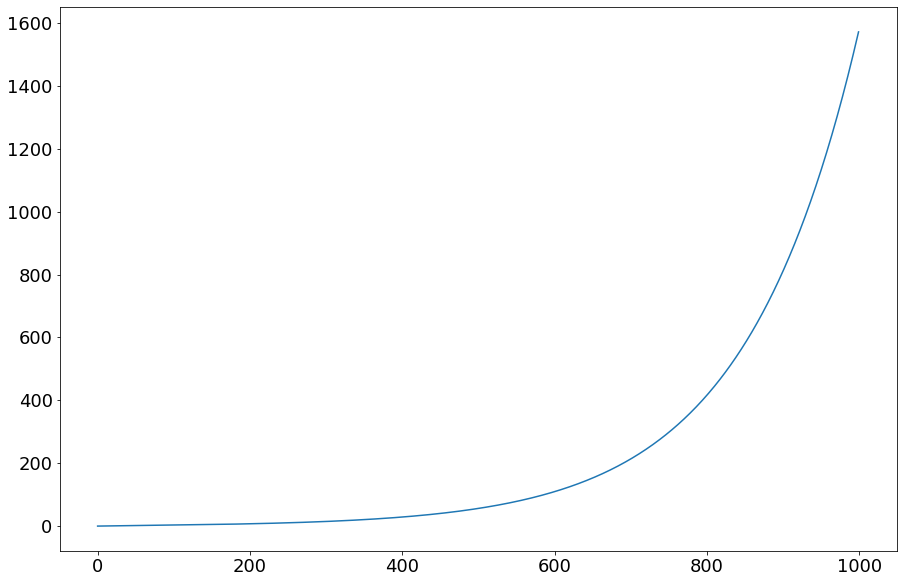

In [9]:
plt.plot(vm3(ts, lbda=1.5, tau=0))

/tmp/ipykernel_18121/1084057792.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return num / den
/tmp/ipykernel_18121/1084057792.py:4: RuntimeWarning: invalid value encountered in true_divide
  return num / den


Text(0, 0.5, 'Vm and Rm units of initial values')

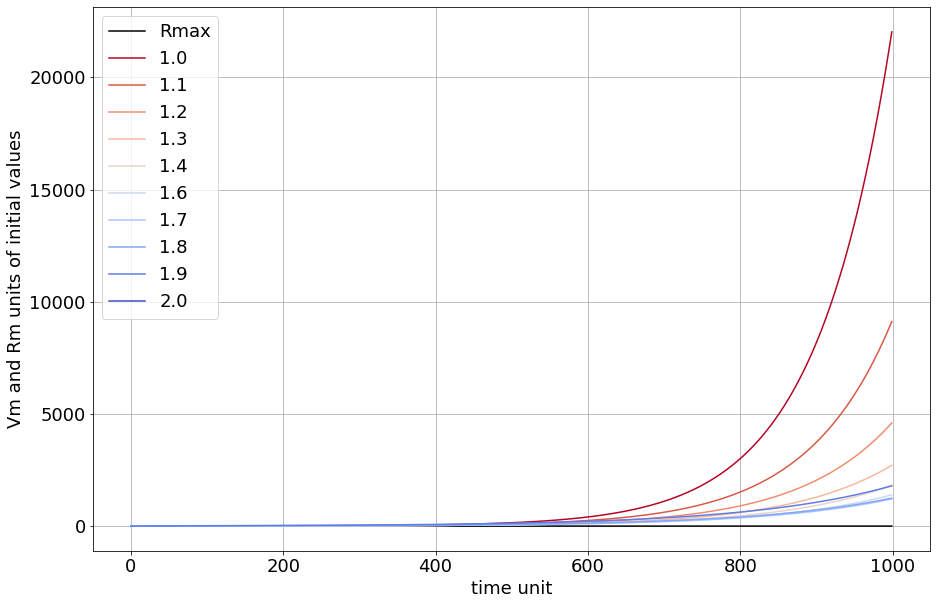

In [10]:
tau    = 0
ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(1, 2, 10)
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.plot(rm(ts),       c='k',       label='Rmax')
for i, lbda in enumerate(lbdas):
    plt.plot(vm3(ts, lbda, tau=tau), label='{:.1f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Vm and Rm units of initial values')

#### Non zero Rmax at t >> 1

Text(0, 0.5, 'Vm and Rm (adimensional)')

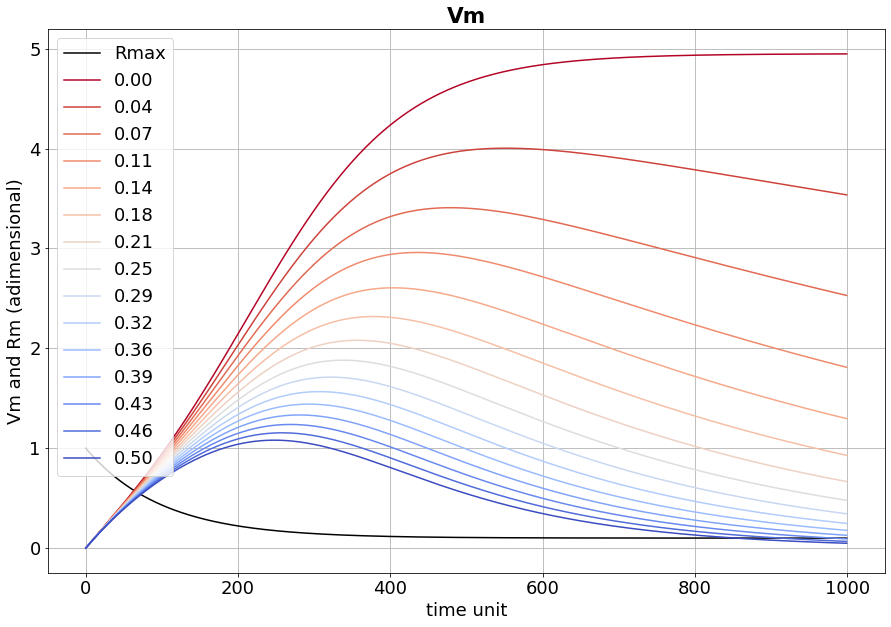

In [11]:
def vm(t, lbda=1.5, r_star=0.25):
    den = np.exp(-t) * (1 - r_star) + r_star
    a   = ((1 - r_star) ** 2) * (np.exp(-2 * t) - np.exp(-lbda * t)) / (lbda - 2)
    b   = r_star * (1 - r_star) * (np.exp(-t) - np.exp(-lbda * t)) / (lbda - 1)
    return (a + b) / den

def rm(t, r_star=0.25):
    return np.exp(-t) + (1 - np.exp(-t)) * r_star

ts     = np.linspace(0, 10, 1000)
lbdas  = np.linspace(0, 0.5, 15)
r_star = 0.1
colors = mpl.cm.coolwarm_r(np.linspace(0, 1, len(lbdas)))

plt.title('Vm', weight='bold')
plt.plot(rm(ts, r_star=r_star),       c='k',       label='Rmax')

for i, lbda in enumerate(lbdas):
    plt.plot(vm(ts, lbda, r_star=r_star), label='{:.2f}'.format(lbda), c=colors[i])
plt.legend()
plt.grid()
plt.xlabel('time unit');plt.ylabel('Vm and Rm (adimensional)')

#### Inner-core

In [18]:
import scipy.integrate as integrate

def get_beta(alpha):
    return (2 - alpha) / alpha

def derivative(u, lbda, alpha):
    '''r0 = 1'''
    beta = get_beta(alpha)
    return (-1 / alpha) * (u ** beta) * np.exp((lbda / alpha) * (1 - u))

def C(T, lbda, alpha):
    C = integrate.quad(
        func=lambda u: derivative(u, lbda, alpha),
        a=0,
        b=T  
    )
    return C

In [56]:
C(2, 0, -2)

/tmp/ipykernel_18121/695030665.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  C = integrate.quad(


(-0.25, 2.2737367544323206e-13)

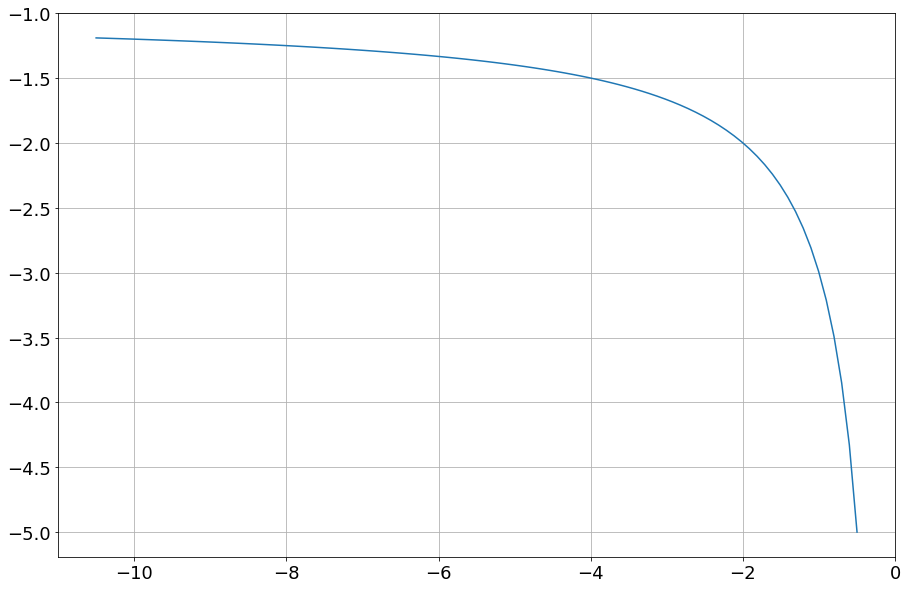

In [45]:
alphas = np.linspace(-0.5, -10.5, 100)

plt.plot(alphas, get_beta(alphas));plt.grid()

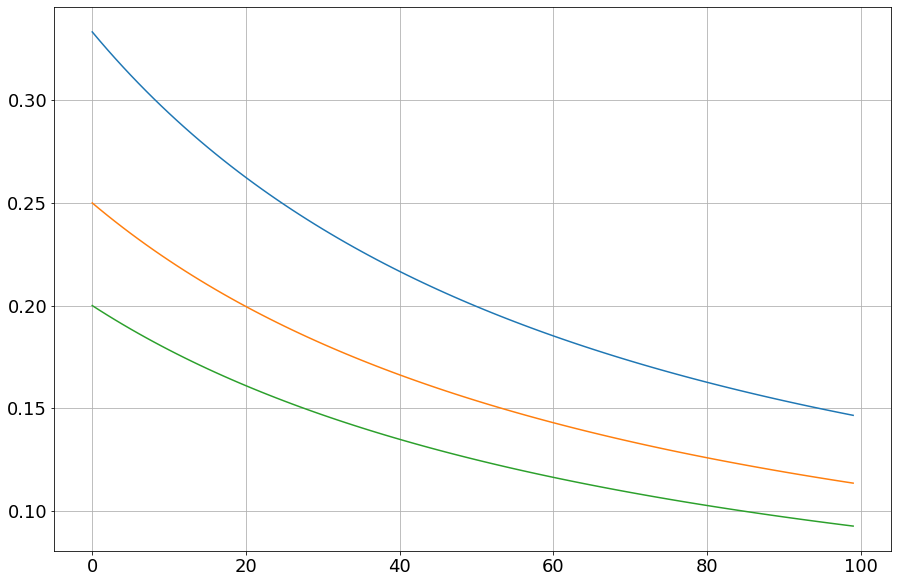

In [55]:
Ts = np.linspace(1, 2, 100)
plt.plot(derivative(Ts, 1, -3))
plt.plot(derivative(Ts, 1, -4))
plt.plot(derivative(Ts, 1, -5))
plt.grid()

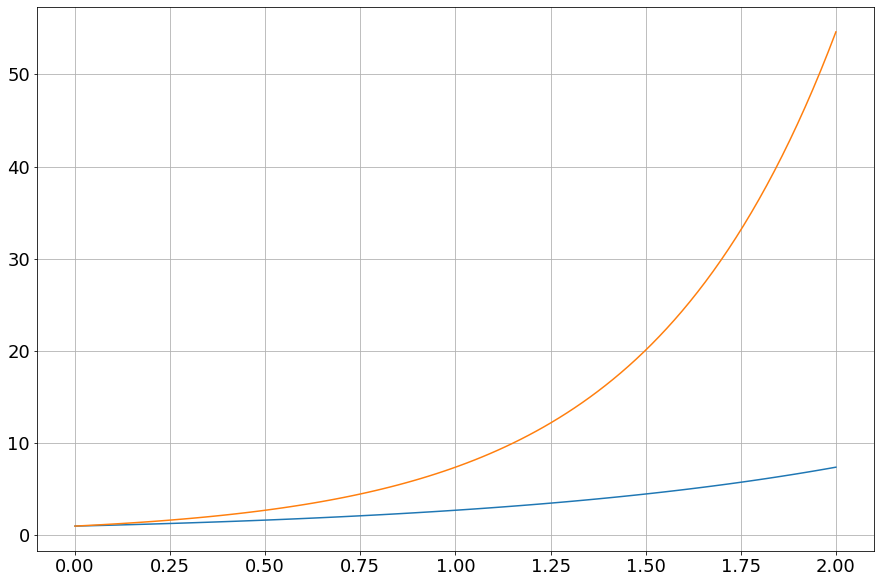

In [71]:
xs = np.linspace(0, 2, 100)
plt.plot(xs, np.exp(xs))
plt.plot(xs, np.exp(2 * xs))
plt.grid()

#### Psi ~ M / r

Text(0, 0.5, 'z')

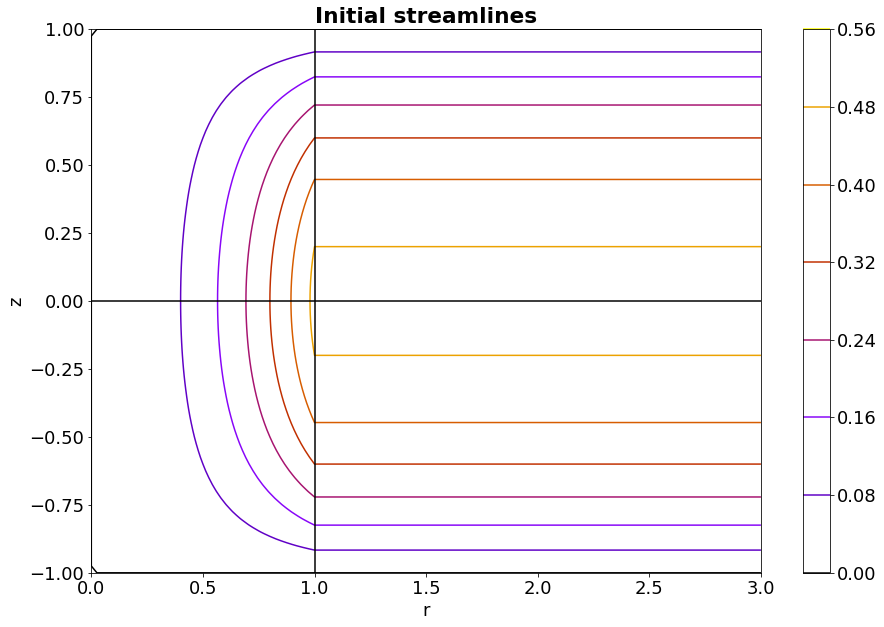

In [192]:
rs   = np.linspace(0, 3, 121)
zs   = np.linspace(-1, 1, 81)
R, Z = np.meshgrid(rs, zs)
# _, Z = np.meshgrid(rs, 1 - zs ** 2)

psi = xr.DataArray(
    data=np.zeros_like(R),
    coords={'z': zs, 'r': rs},
)

psi  = xr.where(psi.r <= 1, 0.5 * psi.r ** 2 * (1 - psi.z ** 2), 0.5 * (1 - psi.z ** 2))

plt.title('Initial streamlines', weight='bold')
plt.contour(R, Z, psi.transpose(), cmap=cm.get_cmap('gnuplot'));plt.colorbar()
plt.axvline(1, c='k');plt.axhline(0, c='k')
plt.xlabel('r');plt.ylabel('z')

/tmp/ipykernel_20532/1612017614.py:4: RuntimeWarning: divide by zero encountered in power
  Mnr = ((lbda * r ** 2 - 2 * r ** lbda) / (lbda * (lbda - 2))) - (np.exp(-lbda * t) / lbda)
/tmp/ipykernel_20532/1612017614.py:4: RuntimeWarning: divide by zero encountered in power
  Mnr = ((lbda * r ** 2 - 2 * r ** lbda) / (lbda * (lbda - 2))) - (np.exp(-lbda * t) / lbda)
/tmp/ipykernel_20532/1612017614.py:4: RuntimeWarning: divide by zero encountered in power
  Mnr = ((lbda * r ** 2 - 2 * r ** lbda) / (lbda * (lbda - 2))) - (np.exp(-lbda * t) / lbda)


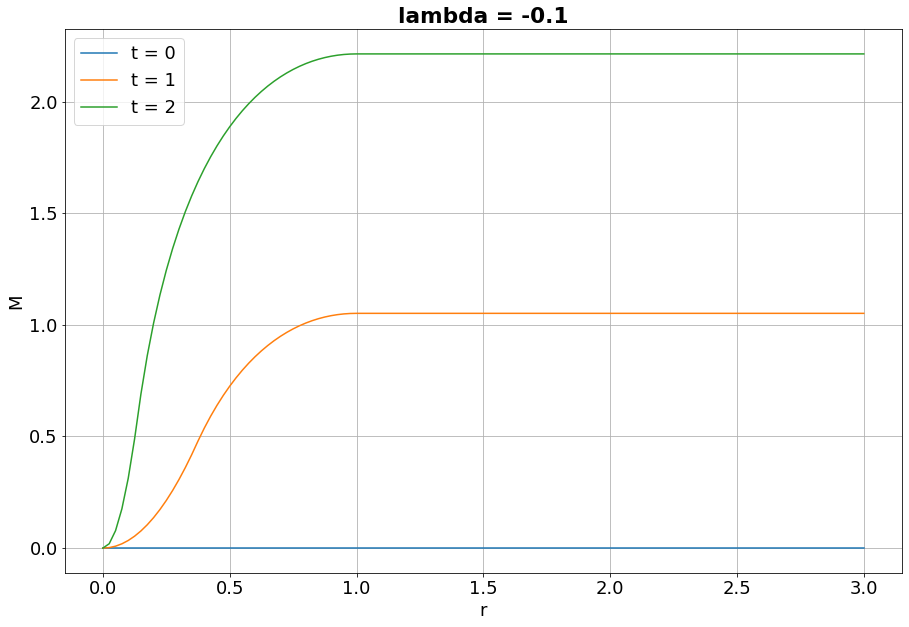

/tmp/ipykernel_20532/1612017614.py:4: RuntimeWarning: divide by zero encountered in power
  Mnr = ((lbda * r ** 2 - 2 * r ** lbda) / (lbda * (lbda - 2))) - (np.exp(-lbda * t) / lbda)
/tmp/ipykernel_20532/1612017614.py:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(rs, M(rs, t=0, lbda=lbda) / rs, label='t = 0')
/tmp/ipykernel_20532/1612017614.py:4: RuntimeWarning: divide by zero encountered in power
  Mnr = ((lbda * r ** 2 - 2 * r ** lbda) / (lbda * (lbda - 2))) - (np.exp(-lbda * t) / lbda)
/tmp/ipykernel_20532/1612017614.py:24: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(rs, M(rs, t=1, lbda=lbda) / rs, label='t = 1')
/tmp/ipykernel_20532/1612017614.py:4: RuntimeWarning: divide by zero encountered in power
  Mnr = ((lbda * r ** 2 - 2 * r ** lbda) / (lbda * (lbda - 2))) - (np.exp(-lbda * t) / lbda)
/tmp/ipykernel_20532/1612017614.py:25: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(rs, M(rs, t=2, lbda=lbda) / rs, labe

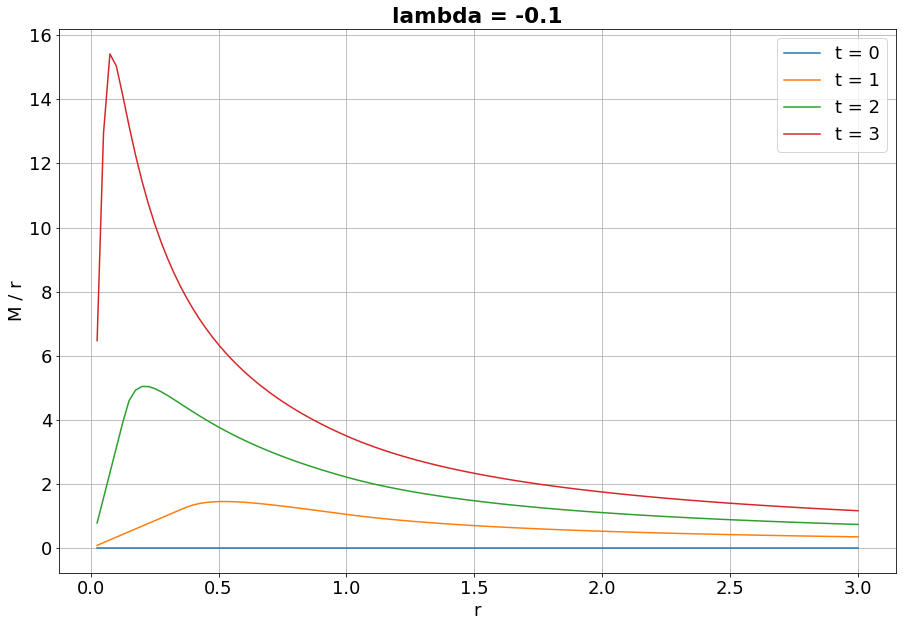

In [253]:
def M(r, t, lbda=1.5):
    M   = r * 0
    Min = (r ** 2) * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)
    Mnr = ((lbda * r ** 2 - 2 * r ** lbda) / (lbda * (lbda - 2))) - (np.exp(-lbda * t) / lbda)
    Mou = (1 - np.exp(-lbda * t)) / lbda
    
    M[r < np.exp(-t)]  = Min[r < np.exp(-t)]
    M[r >= np.exp(-t)] = Mnr[r >= np.exp(-t)]
    M[r >= 1]          = Mou
    
    return M

lbda = -0.1
plt.title('lambda = {}'.format(lbda), weight='bold')
plt.plot(rs, M(rs, t=0, lbda=lbda),   label='t = 0')
plt.plot(rs, M(rs, t=1, lbda=lbda),   label='t = 1')
plt.plot(rs, M(rs, t=2, lbda=lbda),   label='t = 2')
# plt.plot(rs, M(rs, t=100, lbda=lbda), label='t = 100')
plt.legend();plt.grid();plt.ylabel('M');plt.xlabel('r')
plt.show()

plt.title('lambda = {}'.format(lbda), weight='bold')
plt.plot(rs, M(rs, t=0, lbda=lbda) / rs, label='t = 0')
plt.plot(rs, M(rs, t=1, lbda=lbda) / rs, label='t = 1')
plt.plot(rs, M(rs, t=2, lbda=lbda) / rs, label='t = 2')
plt.plot(rs, M(rs, t=3, lbda=lbda) / rs, label='t = 3')
plt.legend();plt.grid();plt.ylabel('M / r');plt.xlabel('r')
plt.show()

/tmp/ipykernel_20532/3287016979.py:4: RuntimeWarning: divide by zero encountered in power
  Mnr = ((lbda * r ** 2 - 2 * r ** lbda) / (lbda * (lbda - 2))) - (np.exp(-lbda * t) / lbda)
/tmp/ipykernel_20532/37930649.py:1: RuntimeWarning: invalid value encountered in true_divide
  da1 = np.matmul(np.expand_dims(np.array(1 - psi.z ** 2), axis=1), np.expand_dims(M(rs, t=1, lbda=lbda) / rs, axis=0))
/tmp/ipykernel_20532/37930649.py:2: RuntimeWarning: invalid value encountered in true_divide
  da2 = np.matmul(np.expand_dims(np.array(1 - psi.z ** 2), axis=1), np.expand_dims(M(rs, t=2, lbda=lbda) / rs, axis=0))
/tmp/ipykernel_20532/37930649.py:3: RuntimeWarning: invalid value encountered in true_divide
  da3 = np.matmul(np.expand_dims(np.array(1 - psi.z ** 2), axis=1), np.expand_dims(M(rs, t=3, lbda=lbda) / rs, axis=0))


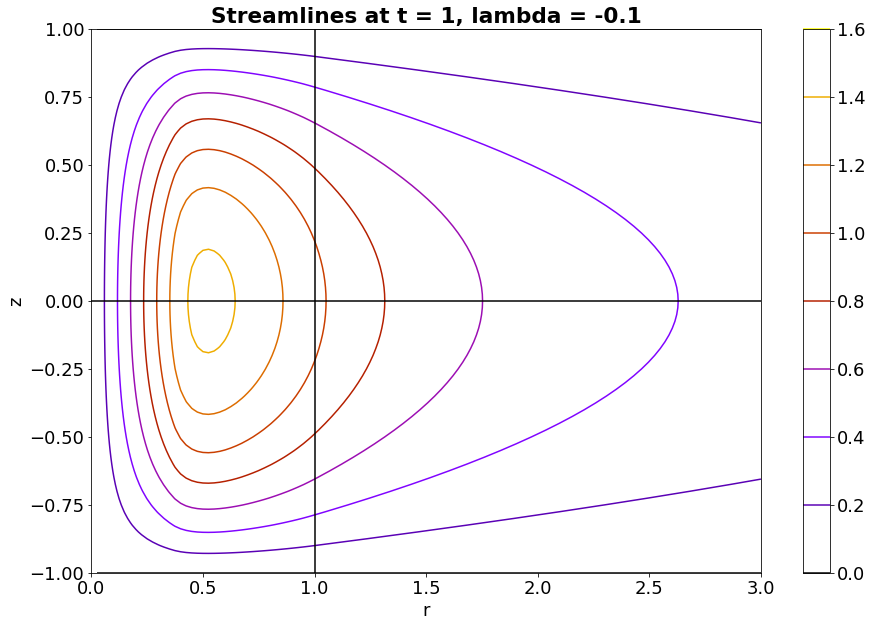

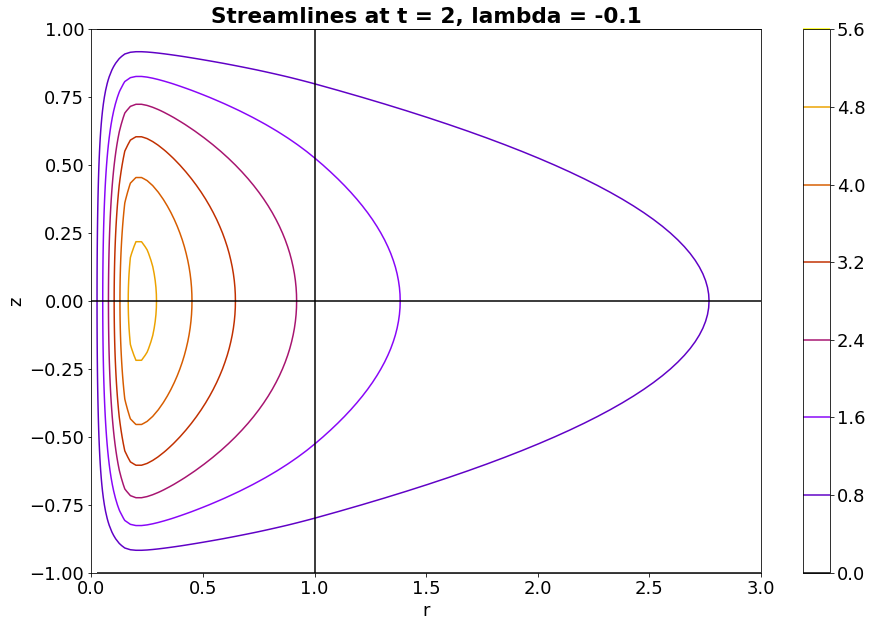

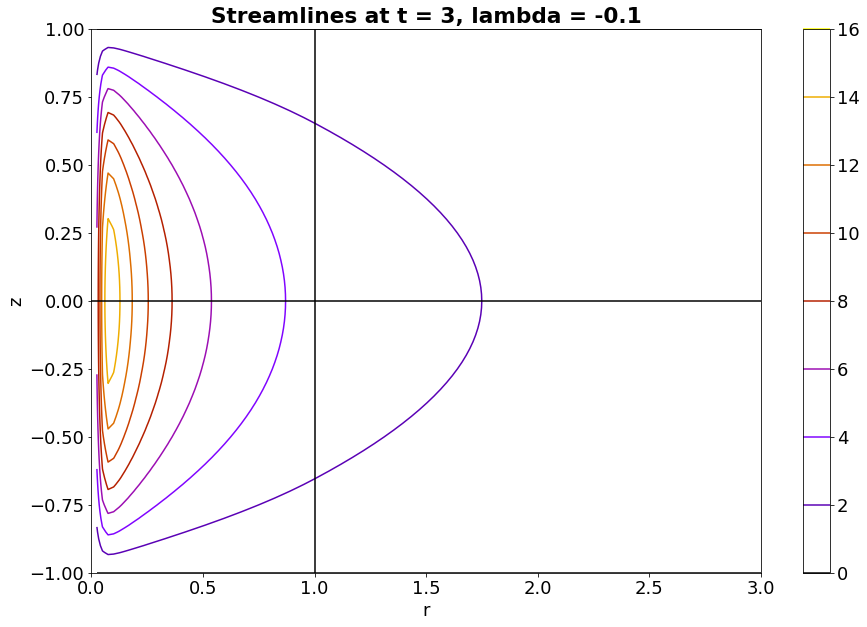

In [252]:
da1 = np.matmul(np.expand_dims(np.array(1 - psi.z ** 2), axis=1), np.expand_dims(M(rs, t=1, lbda=lbda) / rs, axis=0))
da2 = np.matmul(np.expand_dims(np.array(1 - psi.z ** 2), axis=1), np.expand_dims(M(rs, t=2, lbda=lbda) / rs, axis=0))
da3 = np.matmul(np.expand_dims(np.array(1 - psi.z ** 2), axis=1), np.expand_dims(M(rs, t=3, lbda=lbda) / rs, axis=0))

psi1 = xr.DataArray(data=da1, coords={'z': zs, 'r': rs})
psi2 = xr.DataArray(data=da2, coords={'z': zs, 'r': rs})
psi3 = xr.DataArray(data=da3, coords={'z': zs, 'r': rs})

plt.title('Streamlines at t = 1, lambda = {}'.format(lbda), weight='bold')
plt.contour(R, Z, psi1, cmap=cm.get_cmap('gnuplot'));plt.colorbar()
plt.axvline(1, c='k');plt.axhline(0, c='k')
plt.xlabel('r');plt.ylabel('z')
plt.show()

plt.title('Streamlines at t = 2, lambda = {}'.format(lbda), weight='bold')
plt.contour(R, Z, psi2, cmap=cm.get_cmap('gnuplot'));plt.colorbar()
plt.axvline(1, c='k');plt.axhline(0, c='k')
plt.xlabel('r');plt.ylabel('z')
plt.show()

plt.title('Streamlines at t = 3, lambda = {}'.format(lbda), weight='bold')
plt.contour(R, Z, psi3, cmap=cm.get_cmap('gnuplot'));plt.colorbar()
plt.axvline(1, c='k');plt.axhline(0, c='k')
plt.xlabel('r');plt.ylabel('z')
plt.show()

#### Time-dependence

In [261]:
def vmt(t, vm0=1., alpha=0.5, lbda=1.5):
    return vm0 * (1 + np.exp(t)) * np.exp((alpha - lbda) * t) / 2

def rmt(t):
    return 2 / (1 + np.exp(t))

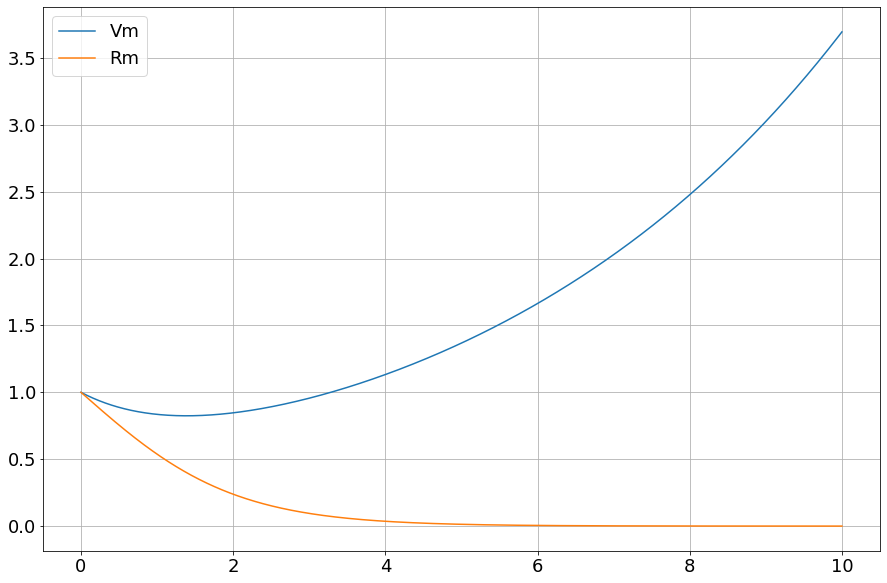

In [280]:
ts = np.linspace(0, 10, 1000)

lbda = 1.3
plt.plot(ts, vmt(ts, lbda=lbda), label='Vm')
plt.plot(ts, rmt(ts), label='Rm')
plt.grid();plt.legend()